# DDOS attack analysis using ML
Distributed Denial of Service attack

In [1]:
from mpl_toolkits.mplot3d import Axes3D #For Basic ploting
from sklearn.preprocessing import StandardScaler #Preprocessing
from sklearn import preprocessing    # Preprocessing
from sklearn.naive_bayes import GaussianNB #import gaussian naive bayes model
from sklearn.tree import DecisionTreeClassifier #import Decision tree classifier
from sklearn import metrics  #Import scikit-learn metrics module for accuracy calculation
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error
import gc


In [2]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]  # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)  # Convert to integer value
    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()



In [3]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number])  # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')  # Use axis='columns' instead of 'columns'
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10:  # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center',
                          va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [4]:
nRowsRead = 1000 # specify No. of row. 'None' for whole data
# test_mosaic.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('test_mosaic.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'test_mosaic.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 78 columns


In [5]:
df1.head(5)

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,53,87750,2,2,72,264,36,36,36.000000,0.000000,...,32.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
1,53,31073,4,4,120,232,30,30,30.000000,0.000000,...,32.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
2,80,41125329,8,1,387,0,188,0,48.375000,80.505435,...,0.0,1218262.0,0.0,1218262.0,1218262.0,37178044.0,0.00,37178044.0,37178044.0,DoS slowloris
3,53,40633,4,4,140,508,35,35,35.000000,0.000000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
4,80,41920705,7,1,211,0,168,0,30.142857,61.300975,...,0.0,2611.0,0.0,2611.0,2611.0,19711185.0,2319322.97,21351194.0,18071176.0,DoS slowloris


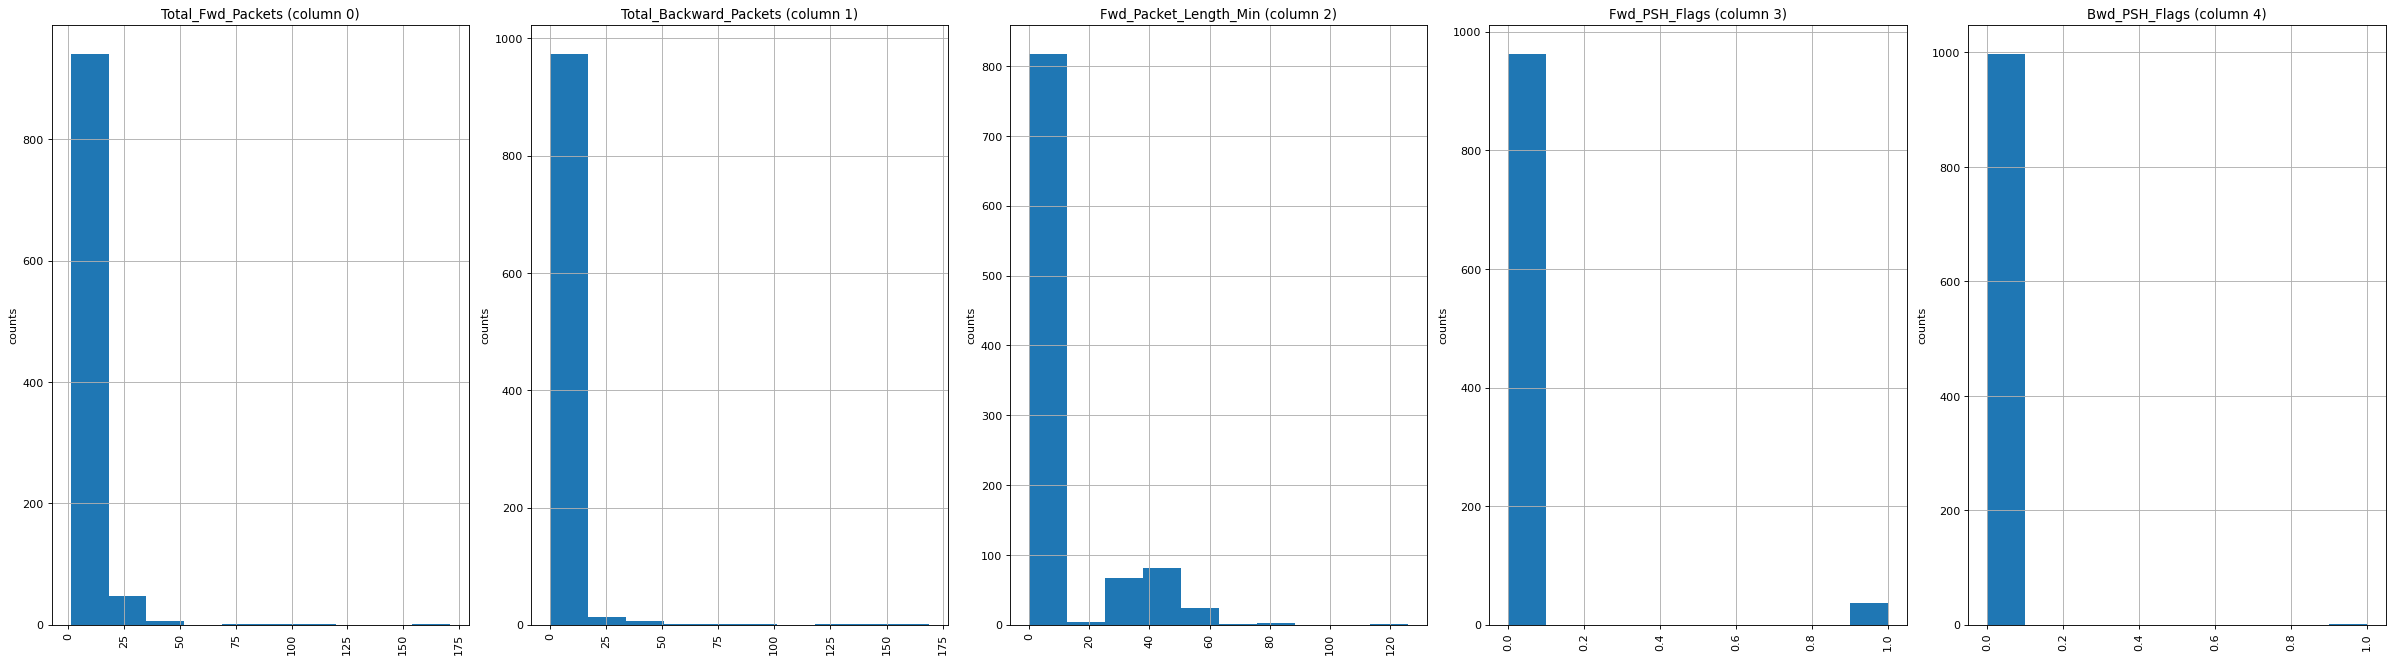

In [6]:
plotPerColumnDistribution(df1, 5, 5)

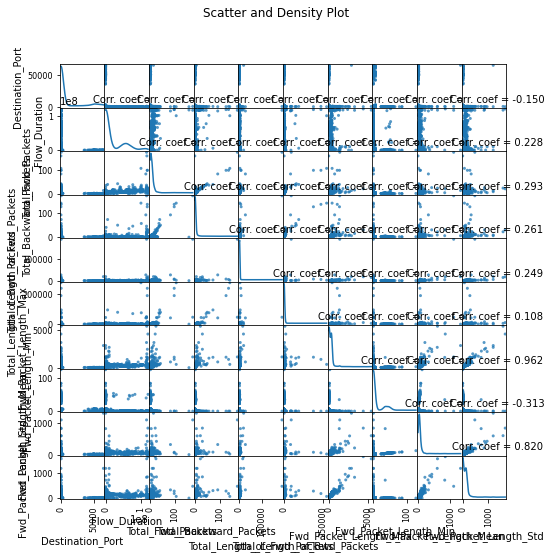

In [7]:
plotScatterMatrix(df1, 8, 10)

In [8]:
df1.shape

(1000, 78)

In [9]:
df1.describe()


,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,act_data_pkt_fwd,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.00000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,4786.506000,2.455804e+07,7.464000,2.878000,666.849000,1594.642000,242.679000,8.21000,51.446205,87.170076,...,2.75700,12.065000,3.565173e+05,1.876442e+05,5.380306e+05,2.238219e+05,1.294874e+07,2.497571e+06,1.511202e+07,1.101356e+07
std,15297.217028,3.572860e+07,10.743096,10.637682,6125.130684,14063.089828,372.166818,16.86067,80.485318,130.232622,...,7.04923,13.866689,9.992068e+05,7.165273e+05,1.713691e+06,8.259443e+05,2.364055e+07,7.521052e+06,2.590348e+07,2.279313e+07
min,0.000000,2.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,80.000000,3.123175e+04,2.000000,1.000000,58.000000,0.000000,35.000000,0.00000,24.527778,0.000000,...,1.00000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,6.335795e+05,6.000000,1.000000,232.500000,0.000000,168.000000,0.00000,40.000000,61.379770,...,1.00000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,80.000000,5.133151e+07,9.000000,2.000000,413.000000,112.000000,350.000000,6.00000,58.020833,132.716130,...,3.00000,20.000000,1.485730e+05,0.000000e+00,2.027890e+05,3.469975e+04,1.877312e+07,0.000000e+00,2.305729e+07,1.084969e+07
max,65116.000000,1.199814e+08,171.000000,169.000000,189037.000000,270887.000000,5472.000000,126.00000,1319.071429,1647.107564,...,146.00000,93.000000,7.889904e+06,1.099243e+07,3.484682e+07,7.889904e+06,1.200000e+08,6.830000e+07,1.200000e+08,1.200000e+08


In [10]:
df1.columns

Index(['Destination_Port', 'Flow_Duration', 'Total_Fwd_Packets',
       'Total_Backward_Packets', 'Total_Length_of_Fwd_Packets',
       'Total_Length_of_Bwd_Packets', 'Fwd_Packet_Length_Max',
       'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean',
       'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Max',
       'Bwd_Packet_Length_Min', 'Bwd_Packet_Length_Mean',
       'Bwd_Packet_Length_Std', 'Flow_Bytes_Sec', 'Flow_Packets_Sec',
       'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min',
       'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max',
       'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Bwd_IAT_Std',
       'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags',
       'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Length',
       'Bwd_Header_Length', 'Fwd_Packets_Sec', 'Bwd_Packets_Sec',
       'Min_Packet_Length', 'Max_Packet_Length', 'Packet_Length_Mean',
       'Packet_Length_Std', 'Packet_Length_Variance', 'FIN_Flag_Count',
       'SYN

In [11]:
df1

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,53,87750,2,2,72,264,36,36,36.000000,0.000000,...,32.0,0.0,0.00000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
1,53,31073,4,4,120,232,30,30,30.000000,0.000000,...,32.0,0.0,0.00000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
2,80,41125329,8,1,387,0,188,0,48.375000,80.505435,...,0.0,1218262.0,0.00000,1218262.0,1218262.0,37178044.0,0.000,37178044.0,37178044.0,DoS slowloris
3,53,40633,4,4,140,508,35,35,35.000000,0.000000,...,20.0,0.0,0.00000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
4,80,41920705,7,1,211,0,168,0,30.142857,61.300975,...,0.0,2611.0,0.00000,2611.0,2611.0,19711185.0,2319322.970,21351194.0,18071176.0,DoS slowloris
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,64800,48,2,1,0,0,0,0,0.000000,0.000000,...,32.0,0.0,0.00000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
996,80,10782200,2,1,0,0,0,0,0.000000,0.000000,...,0.0,7127.0,0.00000,7127.0,7127.0,10800000.0,0.000,10800000.0,10800000.0,DoS Hulk
997,53,35039,1,1,59,124,59,59,59.000000,0.000000,...,32.0,0.0,0.00000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
998,80,56984591,10,1,244,0,168,0,24.400000,50.899029,...,0.0,20732.5,26043.44986,39148.0,2317.0,18710779.0,8209485.577,28076981.0,12762234.0,DoS slowloris


(array([631.,  40.,  12.,  50.,  74.,  67.,  38.,  11.,  33.,  44.]),
 array([2.00000000e+00, 1.19981395e+07, 2.39962770e+07, 3.59944145e+07,
        4.79925520e+07, 5.99906895e+07, 7.19888270e+07, 8.39869645e+07,
        9.59851020e+07, 1.07983240e+08, 1.19981377e+08]),
 <BarContainer object of 10 artists>)

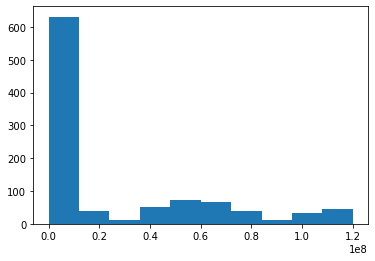

In [12]:
plt.hist(df1['Flow_Duration'])

<AxesSubplot:xlabel='Total_Fwd_Packets', ylabel='Total_Backward_Packets'>

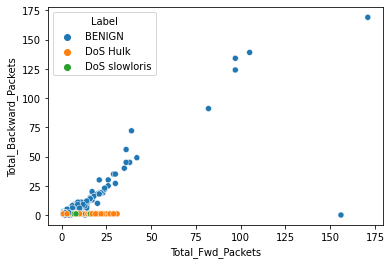

In [13]:
sns.scatterplot(x='Total_Fwd_Packets', y='Total_Backward_Packets', hue='Label', data=df1.sample(1000, random_state=42))

Text(0.5, 1.0, 'Target Variable')

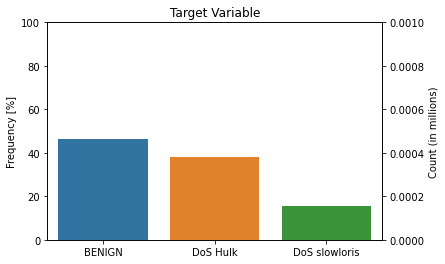

In [14]:
# plotting the target variable
labelCount = df1['Label'].value_counts(normalize=True)*100
ax = sns.barplot(x=labelCount.index, y=labelCount.values)
ax1 = ax.twinx()
ax.set_ylabel('Frequency [%]')
ax1.set_ylabel("Count (in millions)")
ax1.set_ylim(0, len(df1)/10**6)
ax.set_ylim(0, 100)
plt.title('Target Variable')

<AxesSubplot:xlabel='Flow_Duration', ylabel='Count'>

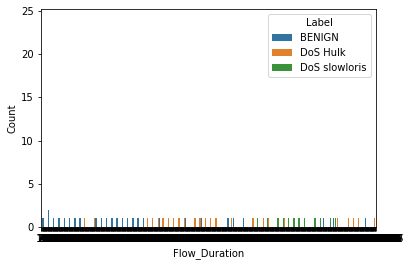

In [15]:
cnt = pd.crosstab(df1['Flow_Duration'], df1['Label'])
cnt = cnt.stack().reset_index().rename(columns={0: 'Count'})
sns.barplot(x=cnt['Flow_Duration'], y=cnt['Count'], hue=cnt['Label'])

In [16]:
nRowsRead = 1000 # specify No. of rows. 'None' for whole file
# train_mosaic.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('train_mosaic.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'train_mosaic.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 78 columns


In [17]:
df2.head()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,80,101168794,20,1,969,0,353,0,48.450000,119.083551,...,0.0,739228.5,743103.4661,1264682.0,213775.0,49700000.0,41400000.0,79000000.0,20500000.0,DoS Hulk
1,60711,58,1,1,0,0,0,0,0.000000,0.000000,...,32.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,53,31146,4,2,148,244,37,37,37.000000,0.000000,...,20.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,80,254704,3,4,429,389,423,0,143.000000,242.505670,...,20.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,443,11932077,12,16,5030,15703,1525,0,419.166667,644.896586,...,20.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [18]:
df2.columns

Index(['Destination_Port', 'Flow_Duration', 'Total_Fwd_Packets',
       'Total_Backward_Packets', 'Total_Length_of_Fwd_Packets',
       'Total_Length_of_Bwd_Packets', 'Fwd_Packet_Length_Max',
       'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean',
       'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Max',
       'Bwd_Packet_Length_Min', 'Bwd_Packet_Length_Mean',
       'Bwd_Packet_Length_Std', 'Flow_Bytes_Sec', 'Flow_Packets_Sec',
       'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min',
       'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max',
       'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Bwd_IAT_Std',
       'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags',
       'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Length',
       'Bwd_Header_Length', 'Fwd_Packets_Sec', 'Bwd_Packets_Sec',
       'Min_Packet_Length', 'Max_Packet_Length', 'Packet_Length_Mean',
       'Packet_Length_Std', 'Packet_Length_Variance', 'FIN_Flag_Count',
       'SYN

In [19]:
df2.describe()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,act_data_pkt_fwd,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
count,1000.000000,1.000000e+03,1000.00000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,4246.673000,2.507349e+07,7.29600,3.123000,468.812000,2.170997e+03,244.328000,9.409000,53.899375,88.947773,...,2.424000,11.720000,3.137636e+05,1.678682e+05,4.531388e+05,1.960724e+05,1.392324e+07,2.477988e+06,1.606655e+07,1.192708e+07
std,14400.585445,3.535078e+07,9.61399,22.584418,1337.061323,3.761453e+04,332.058479,20.825403,90.884050,129.996183,...,3.966353,13.987038,8.689311e+05,5.962103e+05,1.170046e+06,7.568962e+05,2.441193e+07,7.158762e+06,2.636402e+07,2.372149e+07
min,22.000000,1.000000e+00,1.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,80.000000,3.120575e+04,2.00000,1.000000,66.000000,0.000000e+00,40.750000,0.000000,27.364583,0.000000,...,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,9.650500e+05,6.00000,1.000000,296.000000,0.000000e+00,186.000000,0.000000,43.266667,71.483324,...,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,80.000000,5.242769e+07,10.00000,2.000000,433.750000,1.360000e+02,350.250000,6.000000,61.046875,134.721936,...,3.000000,20.000000,1.568442e+05,0.000000e+00,2.155898e+05,3.618600e+04,1.923876e+07,0.000000e+00,2.548050e+07,1.200000e+07
max,65281.000000,1.199663e+08,227.00000,692.000000,28370.000000,1.160103e+06,5840.000000,307.000000,1773.125000,2315.824025,...,82.000000,44.000000,7.410634e+06,5.060878e+06,7.410634e+06,7.410634e+06,1.200000e+08,5.970000e+07,1.200000e+08,1.200000e+08


In [20]:
df2.shape


(1000, 78)

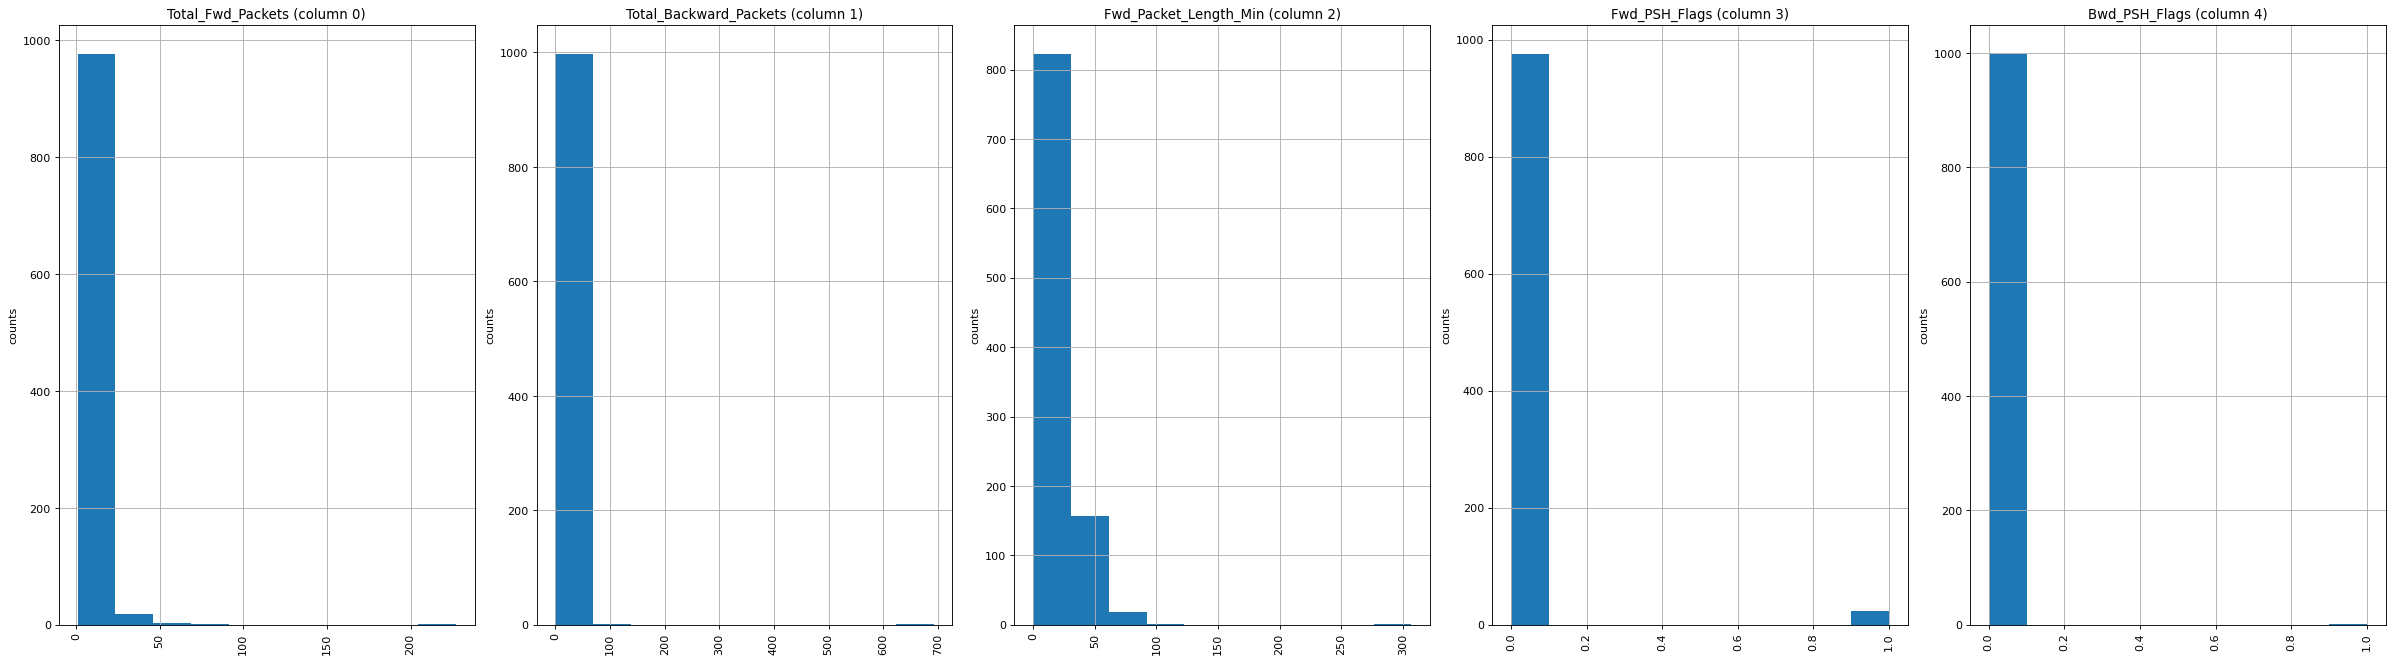

In [21]:
plotPerColumnDistribution(df2, 5, 5)

In [22]:
nRowsRead = 3000 # specify No. of row. 'None' for whole data
# test_mosaic.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
train_data = pd.read_csv('train_mosaic.csv', delimiter=',', nrows = nRowsRead)
train_data.dataframeName = 'train_mosaic.csv'
nRow, nCol = train_data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 3000 rows and 78 columns


In [23]:
train_data.head()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,80,101168794,20,1,969,0,353,0,48.450000,119.083551,...,0.0,739228.5,743103.4661,1264682.0,213775.0,49700000.0,41400000.0,79000000.0,20500000.0,DoS Hulk
1,60711,58,1,1,0,0,0,0,0.000000,0.000000,...,32.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,53,31146,4,2,148,244,37,37,37.000000,0.000000,...,20.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,80,254704,3,4,429,389,423,0,143.000000,242.505670,...,20.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,443,11932077,12,16,5030,15703,1525,0,419.166667,644.896586,...,20.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [24]:
train_data.shape

(3000, 78)

In [25]:
nRowsRead = 3000 # specify No. of row. 'None' for whole data
# test_mosaic.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
test_data = pd.read_csv('test_mosaic.csv', delimiter=',', nrows = nRowsRead)
test_data.dataframeName = 'test_mosaic.csv'
nRow, nCol = test_data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 3000 rows and 78 columns


In [26]:
test_data.head()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,53,87750,2,2,72,264,36,36,36.000000,0.000000,...,32.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
1,53,31073,4,4,120,232,30,30,30.000000,0.000000,...,32.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
2,80,41125329,8,1,387,0,188,0,48.375000,80.505435,...,0.0,1218262.0,0.0,1218262.0,1218262.0,37178044.0,0.00,37178044.0,37178044.0,DoS slowloris
3,53,40633,4,4,140,508,35,35,35.000000,0.000000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
4,80,41920705,7,1,211,0,168,0,30.142857,61.300975,...,0.0,2611.0,0.0,2611.0,2611.0,19711185.0,2319322.97,21351194.0,18071176.0,DoS slowloris


In [27]:
train_data['Label'].unique()
test_data['Label'].unique()

array(['BENIGN', 'DoS slowloris', 'DoS Hulk'], dtype=object)

In [28]:


# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
train_data['Label'] = label_encoder.fit_transform(train_data['Label'])
test_data['Label'] = label_encoder.transform(test_data['Label'])

In [29]:
train_data.head()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,80,101168794,20,1,969,0,353,0,48.450000,119.083551,...,0.0,739228.5,743103.4661,1264682.0,213775.0,49700000.0,41400000.0,79000000.0,20500000.0,1
1,60711,58,1,1,0,0,0,0,0.000000,0.000000,...,32.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,53,31146,4,2,148,244,37,37,37.000000,0.000000,...,20.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,80,254704,3,4,429,389,423,0,143.000000,242.505670,...,20.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0
4,443,11932077,12,16,5030,15703,1525,0,419.166667,644.896586,...,20.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [30]:
test_data.head()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,53,87750,2,2,72,264,36,36,36.000000,0.000000,...,32.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
1,53,31073,4,4,120,232,30,30,30.000000,0.000000,...,32.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
2,80,41125329,8,1,387,0,188,0,48.375000,80.505435,...,0.0,1218262.0,0.0,1218262.0,1218262.0,37178044.0,0.00,37178044.0,37178044.0,2
3,53,40633,4,4,140,508,35,35,35.000000,0.000000,...,20.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
4,80,41920705,7,1,211,0,168,0,30.142857,61.300975,...,0.0,2611.0,0.0,2611.0,2611.0,19711185.0,2319322.97,21351194.0,18071176.0,2


In [31]:
X_train = train_data.drop('Label',axis=1)
X_test = test_data.drop('Label',axis=1)
y_train = train_data['Label']
y_test = test_data['Label']

In [32]:
X_train.head()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,act_data_pkt_fwd,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
0,80,101168794,20,1,969,0,353,0,48.450000,119.083551,...,3.0,0.0,739228.5,743103.4661,1264682.0,213775.0,49700000.0,41400000.0,79000000.0,20500000.0
1,60711,58,1,1,0,0,0,0,0.000000,0.000000,...,0.0,32.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,53,31146,4,2,148,244,37,37,37.000000,0.000000,...,3.0,20.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,80,254704,3,4,429,389,423,0,143.000000,242.505670,...,2.0,20.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,443,11932077,12,16,5030,15703,1525,0,419.166667,644.896586,...,11.0,20.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
y_train.head()

0    1
1    0
2    0
3    0
4    0
Name: Label, dtype: int32

In [34]:
X_test.head()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,act_data_pkt_fwd,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
0,53,87750,2,2,72,264,36,36,36.000000,0.000000,...,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,53,31073,4,4,120,232,30,30,30.000000,0.000000,...,3.0,32.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,80,41125329,8,1,387,0,188,0,48.375000,80.505435,...,4.0,0.0,1218262.0,0.0,1218262.0,1218262.0,37178044.0,0.00,37178044.0,37178044.0
3,53,40633,4,4,140,508,35,35,35.000000,0.000000,...,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,80,41920705,7,1,211,0,168,0,30.142857,61.300975,...,4.0,0.0,2611.0,0.0,2611.0,2611.0,19711185.0,2319322.97,21351194.0,18071176.0


In [35]:
y_test.head()

0    0
1    0
2    2
3    0
4    2
Name: Label, dtype: int32

# Naive Bayes

In [36]:
# create gaussian naive bayes classifier

gnb = GaussianNB()
#Train the model using the training sets
gnb.fit(X_train,y_train)
#Predict the response for test dataset
gnb_pred = gnb.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy : ",metrics.accuracy_score(y_test,gnb_pred))

Accuracy :  0.9436666666666667


# Decision Tree

In [37]:
# Create Decision Tree classifer object

clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
dt_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, dt_pred))

Accuracy: 0.9966666666666667


# SVM

In [38]:

# Create SVM classifier object
clf_svm = svm.SVC()

# Train SVM classifier
clf_svm.fit(X_train, y_train)

# Predict the response for the test dataset
svm_pred = clf_svm.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, svm_pred))


Accuracy: 0.7396666666666667


# K neighbours

In [39]:

# Create KNN classifier object
knn = KNeighborsClassifier()

# Train KNN classifier
knn.fit(X_train, y_train)

# Predict the response for the test dataset
knn_pred = knn.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, knn_pred))


Accuracy: 0.9623333333333334


# Hybrid Model

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Combine the predictions of the three classifiers into a new feature matrix
hybrid_features = np.column_stack((gnb_pred, dt_pred, svm_pred, knn_pred))

# Create Random Forest classifier object
rf = RandomForestClassifier()

# Train Random Forest classifier using the hybrid features and true labels
rf.fit(hybrid_features, y_test)

# Predict the response for the test dataset using the hybrid model
hybrid_pred = rf.predict(hybrid_features)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, hybrid_pred))


Accuracy: 0.9976666666666667


In [41]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Initialize a dictionary to store the accuracy scores
accuracy_dict = {
    'Classifier': ['Gaussian Naive Bayes', 'Decision Tree', 'SVM', 'KNN', 'hybrid'],
    'Accuracy': []
}

# Calculate accuracy for Gaussian Naive Bayes
accuracy_dict['Accuracy'].append(accuracy_score(y_test, gnb_pred))

# Calculate accuracy for Decision Tree
accuracy_dict['Accuracy'].append(accuracy_score(y_test, dt_pred))

# Calculate accuracy for SVM
accuracy_dict['Accuracy'].append(accuracy_score(y_test, svm_pred))

# Calculate accuracy for KNN
accuracy_dict['Accuracy'].append(accuracy_score(y_test, knn_pred))

# Calculate accuracy for Random Forest
accuracy_dict['Accuracy'].append(accuracy_score(y_test, hybrid_pred))

# Create a pandas DataFrame from the accuracy dictionary
accuracy_table = pd.DataFrame(accuracy_dict)

# Display the accuracy table
print(accuracy_table)


             Classifier  Accuracy
0  Gaussian Naive Bayes  0.943667
1         Decision Tree  0.996667
2                   SVM  0.739667
3                   KNN  0.962333
4                hybrid  0.997667


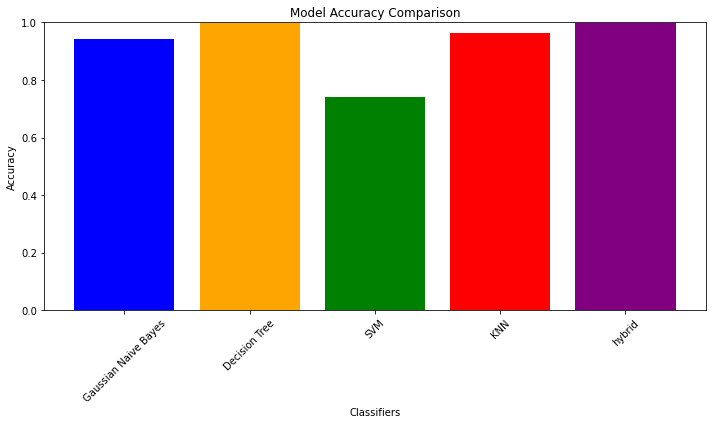

In [42]:
import matplotlib.pyplot as plt

# Define the list of classifier names
classifiers = ['Gaussian Naive Bayes', 'Decision Tree', 'SVM', 'KNN', 'hybrid']
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Define the list of corresponding accuracy scores
accuracies = [metrics.accuracy_score(y_test, gnb_pred),
              metrics.accuracy_score(y_test, dt_pred),
              metrics.accuracy_score(y_test, svm_pred),
              metrics.accuracy_score(y_test, knn_pred),
              metrics.accuracy_score(y_test, hybrid_pred)]

# Plot the bar graph for accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracies,color=colors)
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
